In [1]:
import os
import pickle
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import torch
from torch import nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt

/accounts/grad/khern045/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = 'Fair-ML-Causal-Inference'
law_path = os.path.join('~', base_path, 'data', 'law_data.csv')
data = pd.read_csv(law_path)

data.head()

,Unnamed: 0,race,sex,LSAT,UGPA,region_first,ZFYA,sander_index,first_pf
0,0,White,1,39.0,3.1,GL,-0.98,0.782738,1.0
1,1,White,1,36.0,3.0,GL,0.09,0.735714,1.0
2,2,White,2,30.0,3.1,MS,-0.35,0.670238,1.0
3,5,Hispanic,2,39.0,2.2,NE,0.58,0.697024,1.0
4,6,White,1,37.0,3.4,GL,-1.26,0.786310,1.0


In [3]:
display(data['region_first'].value_counts())
data = data.loc[data['region_first'] != 'PO']

region_first
NE    4302
GL    3822
FW    2904
SE    2651
MS    2346
SC    2251
Mt    1147
NG    1133
MW    1071
NW     163
PO       1
Name: count, dtype: int64

Prepping Data

In [4]:
cols_keep = ['race', 'sex', 'LSAT', 'UGPA', 'ZFYA'] 
law_data = data[cols_keep]
law_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21790 entries, 0 to 21790
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   race    21790 non-null  object 
 1   sex     21790 non-null  int64  
 2   LSAT    21790 non-null  float64
 3   UGPA    21790 non-null  float64
 4   ZFYA    21790 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1021.4+ KB


In [5]:
# visualize the distributions for our OHE data
display(law_data['race'].value_counts(), law_data['sex'].value_counts())

# convert sex to category
law_data.loc[:,'sex'] = np.where(law_data['sex'] == 1, 'Female', 'Male')

race
White          18284
Black           1282
Asian            845
Hispanic         488
Mexican          389
Other            293
Puertorican      110
Amerindian        99
Name: count, dtype: int64

sex
2    12253
1     9537
Name: count, dtype: int64

OHE

In [6]:
# split the data first to avoid data leakage
train, test = train_test_split(law_data, train_size=0.8, random_state=256)

# explicity categories and their unique values
categories = [('sex', list(law_data['sex'].unique())),
              ('race', list(law_data['race'].unique()))]

ohe_columns = [x[0] for x in categories]
ohe_categories = [x[1] for x in categories]

# initialize OHE
enc = OneHotEncoder(sparse=False, categories=ohe_categories, )

# fit and transform the train
train_trans = pd.DataFrame(
    enc.fit_transform(train[ohe_columns]),
    columns = enc.get_feature_names_out(),
    index = train.index
)
# concatenate transformed cols with non transformed
train_trans = pd.concat([train.drop(ohe_columns, axis=1), train_trans], axis=1).reset_index(drop=True)
train_trans.columns = [col.split('_')[1] if '_' in col else col for col in train_trans.columns]


# apply same transformation to test
test_trans = pd.DataFrame(
    enc.fit_transform(test[ohe_columns]),
    columns = enc.get_feature_names_out(),
    index = test.index
)
test_trans = pd.concat([test.drop(ohe_columns, axis=1) ,test_trans], axis=1).reset_index(drop=True)
test_trans.columns = [col.split('_')[1] if '_' in col else col for col in test_trans.columns]


/accounts/grad/khern045/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/accounts/grad/khern045/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
n_train = train_trans.shape[0]
n_test = test_trans.shape[0]

train_trans['LSAT'] = train_trans['LSAT'].round()
test_trans['LSAT'] = test_trans['LSAT'].round()

X_train, y_train = torch.tensor(train_trans.drop(['ZFYA'], axis=1).values, dtype=torch.float32), torch.tensor(train_trans['ZFYA'], dtype=torch.float32) 
X_test, y_test = torch.tensor(test_trans.drop(['ZFYA'], axis=1).values, dtype=torch.float32), torch.tensor(test_trans['ZFYA'], dtype=torch.float32) 

In [8]:
class Dataset(torch.utils.data.Dataset):
     def __init__(self, dataframe):
          self.dataframe = dataframe
      
     def __len__(self):
          return self.dataframe.shape[0]
     
     def __getitem__(self, idx):
          x = torch.tensor(self.dataframe.drop(['ZFYA'], axis=1).loc[idx,:].values, dtype=torch.float32)
          y = torch.tensor(self.dataframe.loc[idx, 'ZFYA'], dtype=torch.float32)
          return x,y

Full Model

In [9]:
# class inherits form a class called nn.Module
class LinearRegressionModel(nn.Module):
    # initialization method for new class
    def __init__(self, input_size, output_size):
        # first thing always do is call initialization method from the parent class, nn.module
        super().__init__()

        # fully connected linear layer
        self.fc1 = nn.Linear(input_size, output_size)

    def forward(self, x):
        # run the linear layer
        output = self.fc1(x)

        return output
    
# evaluate models performance
def evaluate(model, X_train, y_test):
    # Make predictions
    with torch.no_grad(): # disable gradient computation
        predictions = model(X_train).squeeze()

    # Calculate RMSE
    mse = torch.nn.functional.mse_loss(predictions, y_test)
    rmse = np.sqrt(mse.item())

    return rmse

def train(network, train_dataset, test_dataset, file_name_model, n_epochs=10, batch_size = 25):
    assert isinstance(file_name_model, str), "The filename is not a string"
    
    data_loader = torch.utils.data.DataLoader(Dataset(train_dataset), batch_size = batch_size, shuffle=True)
    
    X_test = torch.tensor(test_dataset.drop(['ZFYA'], axis=1).values, dtype=torch.float32)
    y_test = torch.tensor(test_dataset['ZFYA'], dtype=torch.float32)
    
    # Move network to GPU if available
    network = network.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    # define optimizer
    optimizer = torch.optim.Adam(network.parameters())

    # best validation score initialization 
    validation_score_best = float('inf')
    train_losses = []
    validation_scores = []

    # train loop
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch in tqdm(data_loader, leave=False):
            # unpack batch
            X, y = batch

            # zero parameter gradients
            optimizer.zero_grad()
            
            # forward pass to get input
            # output is of shape [20,1] but we want of size [20] to compare 
            output = network(X).squeeze()

            # calculate loss
            loss = nn.MSELoss()(output, y)
            epoch_loss += loss.item()
            # root_loss = torch.sqrt(loss)
            
            # backward pass and optimize
            loss.backward()
            optimizer.step() # update model parameters
        
        avg_epoch_loss = epoch_loss / len(data_loader)  # Average loss per epoch
        train_losses.append(avg_epoch_loss)  # Append average epoch loss
        
        validation_score = evaluate(network, X_test, y_test) # evaluation mode
        validation_scores.append(validation_score)
        if epoch % 5 == 0:
            print(f'Epoch {epoch+1}, validation score: {validation_score}')
        network.train() # back to train mode

        if validation_score < validation_score_best:
            validation_score_best = validation_score
            torch.save(network.state_dict(), file_name_model+'.pt') 
            
    print(f'Best validation score:{validation_score_best}')
    return validation_scores, train_losses

In [10]:
# create and train model
full_model = LinearRegressionModel(train_trans.shape[1]-1, 1)
full_model.load_state_dict(torch.load('full_model.pt'))
# full_validation_scores, full_train_losses = train(full_model, train_trans, test_trans, 'full_model', n_epochs=15, batch_size=20)

<All keys matched successfully>

Unaware Model

In [11]:
protected_attributes = ['Female', 'Male', 'White', 'Hispanic', 'Asian', 'Black', 'Other', 'Mexican', 'Puertorican', 'Amerindian']

train_unaware = train_trans.drop(protected_attributes, axis=1)
test_unaware = test_trans.drop(protected_attributes, axis=1)

unaware_model = LinearRegressionModel(train_unaware.shape[1]-1, 1)
unaware_model.load_state_dict(torch.load('unaware_model.pt'))
# unaware_validation_scores, unaware_train_losses = train(unaware_model, train_unaware, test_unaware, 'unaware_model', n_epochs=15, batch_size=20)

<All keys matched successfully>

Fair K

In [24]:

def FairKModel(R, S, GPA=None, LSAT=None, FYA=None, num_observations=None):
    num_race_cats = len(law_data['race'].unique())
    num_sex_cats = len(law_data['sex'].unique())    

    # 0,1 vectors for the normal distribution
    # R and S are matrices
    r0_vec = torch.zeros(num_race_cats)
    s0_vec = torch.zeros(num_sex_cats)
    r1_vec = torch.ones(num_race_cats)
    s1_vec = torch.ones(num_sex_cats)

    # prior latent variable 'K' (knowledge)
    K = pyro.sample('K', dist.Normal(torch.tensor(0.), torch.tensor(1.)))

    # priors for weights and baselines for GPA, LSAT and FYA
    # GPA ~ N(b_G  + w_G^K K + w_G^R R + w_G^S S, \sigma_G)
    b_G = pyro.sample('b_G', dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    w_G_K = pyro.sample('w_G_K', dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    w_G_R = pyro.sample('w_G_R', dist.Normal(r0_vec,r1_vec)) # outputs a vec of normals of len(race)
    w_G_S = pyro.sample('w_G_S', dist.Normal(s0_vec,s1_vec)) # outputs a vec of normals of len(sex)
    sigma_G = pyro.sample('sigma_G', dist.InverseGamma(torch.tensor(1.), torch.tensor(1.)))

    # LSAT ~ Poisson(exp( b_L +w_L^K K + w_L^R R + w_L^S S))
    b_L = pyro.sample('b_L', dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    w_L_K = pyro.sample('w_L_K', dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    w_L_R = pyro.sample('w_L_R', dist.Normal(r0_vec,r1_vec))
    w_L_S = pyro.sample('w_L_S', dist.Normal(s0_vec,s1_vec))

    # FYA ~ N(w_F^K K + w_F^R R + w_F^S S, 1)
    w_F_K = pyro.sample('w_F_K', dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    w_F_R = pyro.sample('w_F_R', dist.Normal(r0_vec,r1_vec))
    w_F_S = pyro.sample('w_F_S', dist.Normal(s0_vec,s1_vec))

    # Calculate the parameters values of the data generating distributions
    # print(len(b_G))
    # print(len(w_G_K * K))
    # print((torch.matmul(w_G_R, R.transpose(0,1))).shape)
    # # w 1 x num_col_race
    # # R len_race x num_col_race
    # print((torch.matmul(w_G_S, S)).shape)

    mu_G = b_G + w_G_K * K + torch.matmul(w_G_R, R.transpose(0,1)) + torch.matmul(w_G_S, S.transpose(0,1))
    lambda_L = b_L + w_L_K * K + torch.matmul(w_L_R, R.transpose(0,1)) + torch.matmul(w_L_S, S.transpose(0,1))
    mu_F = w_F_K * K + torch.matmul(w_F_R, R.transpose(0,1)) + torch.matmul(w_F_S, S.transpose(0,1))

    # sample observed data
    # pyro.plate is to denote independent observations and for vectorized computation
    # use if dealing with multiple observations
    with pyro.plate('data', num_observations):
        # gives likelihood of observed data given model parameters
        gpa = pyro.sample('gpa', dist.Normal(mu_G, sigma_G), obs=GPA) # obs is observed
        lsat = pyro.sample('lsat', dist.Poisson(lambda_L.exp()), obs=LSAT)
        fya = pyro.sample('fya', dist.Normal(mu_F, torch.tensor(1.)), obs=FYA)

    return gpa, lsat, fya

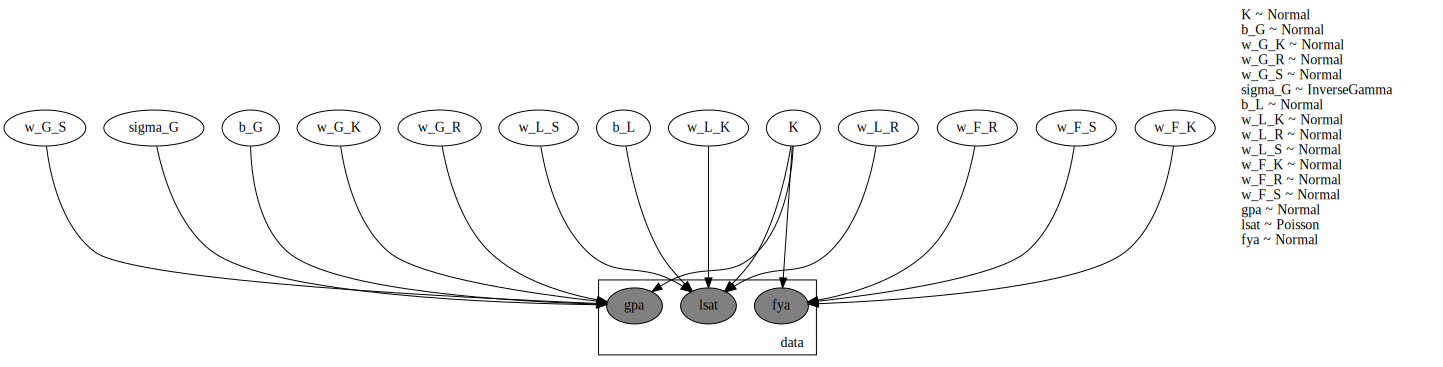

In [26]:
train_tensor = torch.tensor(train_trans.values, dtype=torch.float32)
model_graph = pyro.render_model(
    FairKModel, 
    model_args=(train_tensor[:,5:], train_tensor[:,3:5], train_tensor[:,1], train_tensor[:,0], train_tensor[:,2], train_tensor.shape[0]),
    render_distributions=True, 
    render_params=True
    )
model_graph


In [17]:
train_tensor.shape[0]

17432